## 1. Loading necessary libraries

In [1]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
import plotly.express as px

np.warnings = warnings

In [2]:
from umap import UMAP
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append("..")

# import utility functions
import src.utils as util
reload(util)

import src.load_parquet as load_parquet
reload(load_parquet)

# setup OS agnostic pathnames
ROOT_DIR = Path('..')

# Note: to run main notebook from root directory, use:
# ROOT_DIR = Path('')

import src.DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

# import modelling_pipeline as modelling_pipeline
# reload(modelling_pipeline)

# modelling_pipeline = modelling_pipeline.modelling_pipeline(ROOT_DIR)

In [4]:
# load libraries and modules
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectFromModel

# model comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# evaluation metrics
from sklearn.metrics import cohen_kappa_score,classification_report 
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, auc, make_scorer
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, balanced_accuracy_score
from sklearn.metrics import PrecisionRecallDisplay

## 2. Loading Data

In [5]:
df_desc_icd, df_desc_labitems, df_desc_items = dataLoader.load_descriptions()
df_diagnoses_icd = dataLoader.load_diagnoses_icd(df_desc_icd)
df_demographic = dataLoader.load_demographic(df_diagnoses_icd)
df_demographic = dataLoader.demographic_clean_AGE(df_demographic)
df_labevents = dataLoader.load_labevents(df_demographic)
df_labevents = dataLoader.labevents_compute_TIME(df_labevents, df_demographic)

Removed 8210 admissions with AGE < 18


## 3. Input Dataset Extraction

In [6]:
# t0
dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=0, feature_no=20)

In [7]:
# t2
dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=2, feature_no=20)

In [8]:
# t4
dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=4, feature_no=20)

## 4. Data processing

### 4.1 Train/ test split

In [10]:
path_t0_df = ROOT_DIR / 'data' / 'Model input data' / "t0.csv"  
t0_df = pd.read_csv(path_t0_df)

In [11]:
path_t2_df = ROOT_DIR / 'data' / 'Model input data' / "t2.csv"  
t2_df = pd.read_csv(path_t2_df)
path_t4_df = ROOT_DIR / 'data' / 'Model input data' / "t4.csv"  
t4_df = pd.read_csv(path_t4_df)

In [12]:
def split_data(df_train):
    """
    Split data into training and test sets.
    Standardise numerical features.
    
    Compare performances of different models.
    Perform hyperparameter tuning on best model.
    Validate the optimal model's performance on the test set.
    Generate predictions for unknown data using the optimal model.
    
    Parameters:
    - df_train: Processed data for model training
    - test_size: 
    
    Returns:
    - X train, X test, y train, y test 
    """
         
    # Target and Predictors
    X = df_train.drop('IS_SEPSIS', axis='columns')
    y = df_train['IS_SEPSIS']
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    # Fit the scaler and transform the X train and test sets
    # Standardising (not normalising!)
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

### 4.2 Feature Scaling

In [13]:
X_t0_train, X_t0_test, y_t0_train, y_t0_test = split_data(t0_df)

In [14]:
X_t2_train, X_t2_test, y_t2_train, y_t2_test = split_data(t2_df)
X_t4_train, X_t4_test, y_t4_train, y_t4_test = split_data(t4_df)

## 5. Model Fitting

### 5.1 Logistic regression

In [15]:
# Calculate class weights
label_counts = y_t0_train.value_counts()
class_weights = {0: 1/(label_counts[0]/len(y_t0_train)), 1: 1/(label_counts[1]/len(y_t0_train))}

# Round the class weights to the desired precision (optional)
class_weights = {key: round(weight, 4) for key, weight in class_weights.items()}

print("Class Weights:", class_weights)

Class Weights: {0: 1.1273, 1: 8.855}


In [16]:
label_counts[0]/len(y_t0_train)

0.8870692472493554

In [17]:
label_counts[1]/len(y_t0_train)

0.11293075275064454

#### 5.1.2 t2

In [18]:
# Fitting a Logistic Regression Classifier
t2_lr = LogisticRegression(random_state=901, class_weight=class_weights)
t2_lr.fit(X_t2_train, y_t2_train)

t2_lr_predictions = t2_lr.predict(X_t2_test)
t2_lr_predicted_probabilities = t2_lr.predict_proba(X_t2_test)

c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### UMAP t2 LR

In [41]:
reducer = UMAP(n_components=2, random_state=42)

X_t2_train_transformed = reducer.fit_transform(X_t2_train)


C:\Users\Nyamtsetseg\AppData\Roaming\Python\Python310\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [40]:
# 1. Transform the test data using UMAP

X_t2_test_transformed = reducer.transform(X_t2_test)

AttributeError: 'UMAP' object has no attribute '_raw_data'

In [23]:
# 2. Determine whether each prediction was correct
is_correct = (t2_lr_predictions == y_t2_test).astype(int)  # 1 for correct predictions and 0 for incorrect predictions

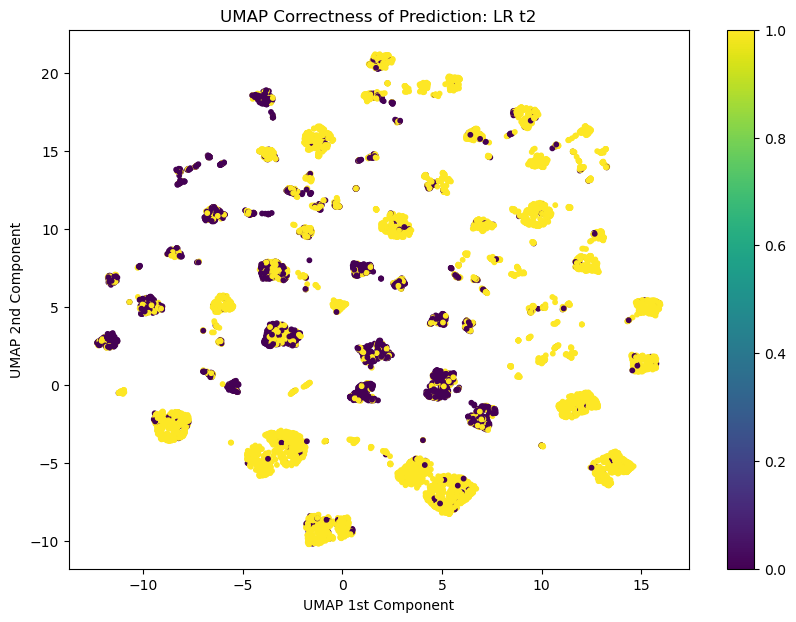

In [28]:
# 3. Plot the UMAP-transformed test data, colored by correctness of prediction
plt.figure(figsize=(10,7))
plt.scatter(X_t2_test_transformed[:, 0], X_t2_test_transformed[:, 1], c=is_correct, cmap='viridis', s=10)
plt.colorbar()
plt.gca().set_title('UMAP Correctness of Prediction: LR t2')
plt.xlabel("UMAP 1st Component")
plt.ylabel('UMAP 2nd Component')
plt.show()


#### 5.1.3 t4

In [25]:
# Fitting a Logistic Regression Classifier
t4_lr = LogisticRegression(random_state=901, class_weight=class_weights)
t4_lr.fit(X_t4_train, y_t4_train)

t4_lr_predictions = t4_lr.predict(X_t4_test)
t4_lr_predicted_probabilities = t4_lr.predict_proba(X_t4_test)

c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### UMAP t4 LR

In [29]:
reducer = UMAP(n_components=2, random_state=42)

X_t4_train_transformed = reducer.fit_transform(X_t4_train)

C:\Users\Nyamtsetseg\AppData\Roaming\Python\Python310\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [31]:
# 1. Transform the test data using UMAP
X_t4_test_transformed = reducer.transform(X_t4_test)

In [33]:
# 2. Determine whether each prediction was correct
is_correct = (t4_lr_predictions == y_t4_test).astype(int) # 1 for correct predictions and 0 for incorrect predictions

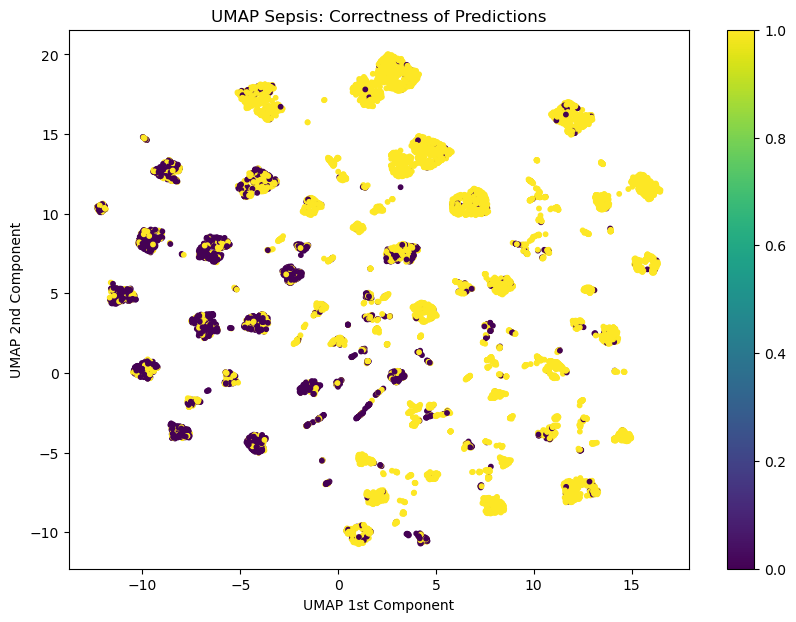

In [34]:
# 3. Plot the UMAP-transformed test data, colored by correctness of prediction
plt.figure(figsize=(10,7))
plt.scatter(X_t4_test_transformed[:, 0], X_t4_test_transformed[:, 1], c=is_correct, cmap='viridis', s=10)
plt.colorbar()
plt.gca().set_title('UMAP Sepsis: Correctness of Predictions')
plt.xlabel("UMAP 1st Component")
plt.ylabel('UMAP 2nd Component')
plt.show()

### 5.2 Random Forest

#### 5.2.1 t0

In [35]:
t0_rf_best = RandomForestClassifier(random_state=901,class_weight=class_weights, max_depth=7, min_samples_leaf=25, min_samples_split=250)
t0_rf_best.fit(X_t0_train, y_t0_train)

# Predict the test set using the best random forest regressor
y_pred_rf = t0_rf_best.predict(X_t0_test)
y_pred_rf = np.round(y_pred_rf) # Round the predictions to the nearest integer
t0_rf_predicted_probabilities = t0_rf_best.predict_proba(X_t0_test)

In [36]:
# Define the RMSE scoring metric as a callable
def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return sqrt(mse)

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Compute the RMSE of the predictions on the test set
rmse_rf = np.sqrt(mean_squared_error(y_t0_test, y_pred_rf))
print("Random Forest Classifier Test set RMSE: {:.4f}".format(rmse_rf))

Random Forest Classifier Test set RMSE: 0.5175


#### 5.2.2 t2

In [37]:
t2_rf_best = RandomForestClassifier(random_state=901,class_weight=class_weights, max_depth=7, min_samples_leaf=25, min_samples_split=250)
t2_rf_best.fit(X_t2_train, y_t2_train)

# Predict the test set using the best random forest regressor
y_pred_t2_rf = t2_rf_best.predict(X_t2_test)
y_pred_t2_rf = np.round(y_pred_t2_rf) # Round the predictions to the nearest integer
t2_rf_predicted_probabilities = t2_rf_best.predict_proba(X_t2_test)

In [38]:
# Compute the RMSE of the predictions on the test set
rmse_t2_rf = np.sqrt(mean_squared_error(y_t2_test, y_pred_t2_rf))
print("Random Forest Classifier Test set RMSE: {:.4f}".format(rmse_t2_rf))

Random Forest Classifier Test set RMSE: 0.4885


### UMAP t2 RF

In [42]:
# 1. Use UMAP to reduce the dimensionality of the test data
reducer = UMAP(n_components=2, random_state=42)
X_t2_test_transformed = reducer.fit_transform(X_t2_test)

C:\Users\Nyamtsetseg\AppData\Roaming\Python\Python310\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [45]:
# 2. Determine whether each prediction was correct
is_correct_test = (y_pred_t2_rf == y_t2_test).astype(int)  # 1 for correct predictions and 0 for incorrect predictions

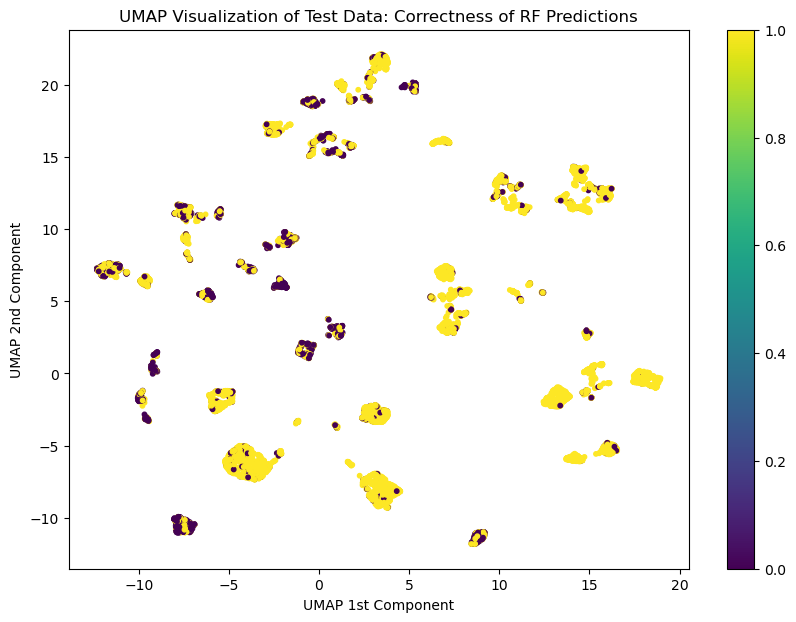

In [46]:
# 3. Plot the UMAP-transformed test data, colored by correctness of prediction
plt.figure(figsize=(10,7))
plt.scatter(X_t2_test_transformed[:, 0], X_t2_test_transformed[:, 1], c=is_correct_test, cmap='viridis', s=10)
plt.colorbar()
plt.gca().set_title('UMAP Visualization of Test Data: Correctness of RF Predictions')
plt.xlabel("UMAP 1st Component")
plt.ylabel('UMAP 2nd Component')
plt.show()

#### 5.2.3 t4

In [47]:
t4_rf_best = RandomForestClassifier(random_state=901,class_weight=class_weights, max_depth=7, min_samples_leaf=25, min_samples_split=250)
t4_rf_best.fit(X_t4_train, y_t4_train)

# Predict the test set using the best random forest regressor
y_pred_t4_rf = t4_rf_best.predict(X_t4_test)
y_pred_t4_rf = np.round(y_pred_t4_rf) # Round the predictions to the nearest integer
t4_rf_predicted_probabilities = t4_rf_best.predict_proba(X_t4_test)

In [48]:
# Compute the RMSE of the predictions on the test set
rmse_t4_rf = np.sqrt(mean_squared_error(y_t4_test, y_pred_t4_rf))
print("Random Forest Classifier Test set RMSE: {:.4f}".format(rmse_t4_rf))

Random Forest Classifier Test set RMSE: 0.4843


### UMAP t4 RF

In [49]:
# 1. Use UMAP to reduce the dimensionality of the test data
reducer = UMAP(n_components=2, random_state=42)
X_t4_test_transformed = reducer.fit_transform(X_t4_test)

C:\Users\Nyamtsetseg\AppData\Roaming\Python\Python310\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [50]:
# 2. Determine whether each prediction was correct
is_correct_test = (y_pred_t4_rf == y_t4_test).astype(int)  # 1 for correct predictions and 0 for incorrect predictions

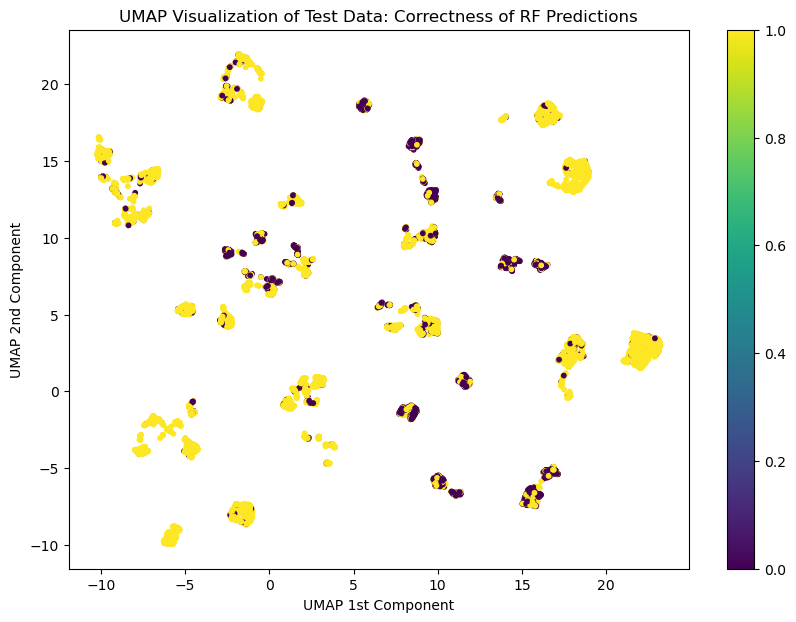

In [51]:
# 3. Plot the UMAP-transformed test data, colored by correctness of prediction
plt.figure(figsize=(10,7))
plt.scatter(X_t4_test_transformed[:, 0], X_t4_test_transformed[:, 1], c=is_correct_test, cmap='viridis', s=10)
plt.colorbar()
plt.gca().set_title('UMAP Visualization of Test Data: Correctness of RF Predictions')
plt.xlabel("UMAP 1st Component")
plt.ylabel('UMAP 2nd Component')
plt.show()

### 5.3 Gradient Boosting

#### 5.3.2 t2

In [53]:
# Initialize the Gradient Boosting Classifier
t2_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=901)

# Train the classifier on the training data
t2_gb.fit(X_t2_train, y_t2_train, sample_weight=[class_weights[label] for label in y_t2_train])

# Predict on the test set
y_t2_pred = t2_gb.predict(X_t2_test)
t2_gb_predicted_probabilities = t2_gb.predict_proba(X_t2_test)

### UMAP t2 GB

In [52]:
# 1. Use UMAP to reduce the dimensionality of the test data
reducer = UMAP(n_components=2, random_state=42)
X_t2_test_transformed = reducer.fit_transform(X_t2_test)

C:\Users\Nyamtsetseg\AppData\Roaming\Python\Python310\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [54]:
# 2. Determine whether each prediction was correct
is_correct_test = (y_t2_pred == y_t2_test).astype(int)  # 1 for correct predictions and 0 for incorrect predictions

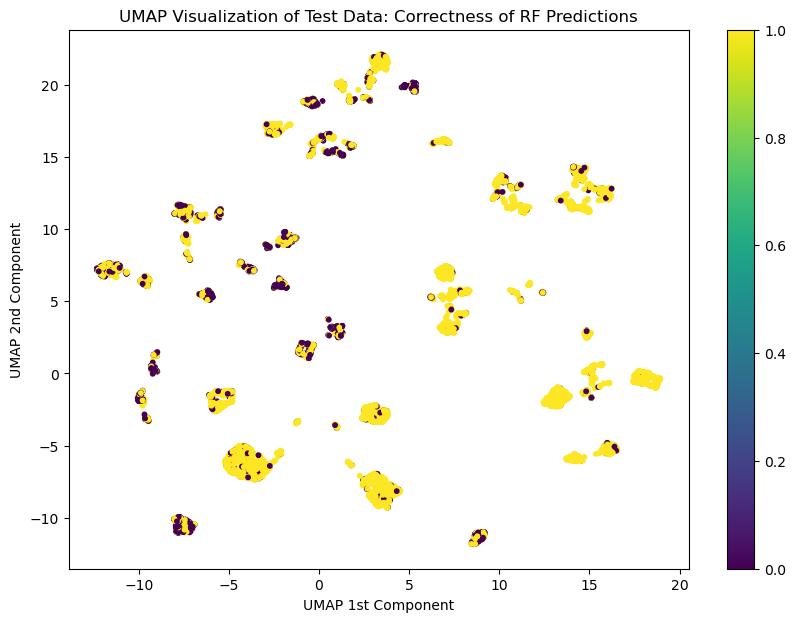

In [55]:
# 3. Plot the UMAP-transformed test data, colored by correctness of prediction
plt.figure(figsize=(10,7))
plt.scatter(X_t2_test_transformed[:, 0], X_t2_test_transformed[:, 1], c=is_correct_test, cmap='viridis', s=10)
plt.colorbar()
plt.gca().set_title('UMAP Visualization of Test Data: Correctness of RF Predictions')
plt.xlabel("UMAP 1st Component")
plt.ylabel('UMAP 2nd Component')
plt.show()

#### 5.3.3 t4

In [58]:
# Initialize the Gradient Boosting Classifier
t4_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=901)

# Train the classifier on the training data
t4_gb.fit(X_t4_train, y_t4_train, sample_weight=[class_weights[label] for label in y_t4_train])

# Predict on the test set
y_t4_pred = t4_gb.predict(X_t4_test)
t4_gb_predicted_probabilities = t4_gb.predict_proba(X_t4_test)

### UMAP t4 GB

In [56]:
# 1. Use UMAP to reduce the dimensionality of the test data
reducer = UMAP(n_components=2, random_state=42)
X_t4_test_transformed = reducer.fit_transform(X_t4_test)

C:\Users\Nyamtsetseg\AppData\Roaming\Python\Python310\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [59]:
# 2. Determine whether each prediction was correct
is_correct_test = (y_t4_pred == y_t4_test).astype(int)  # 1 for correct predictions and 0 for incorrect predictions

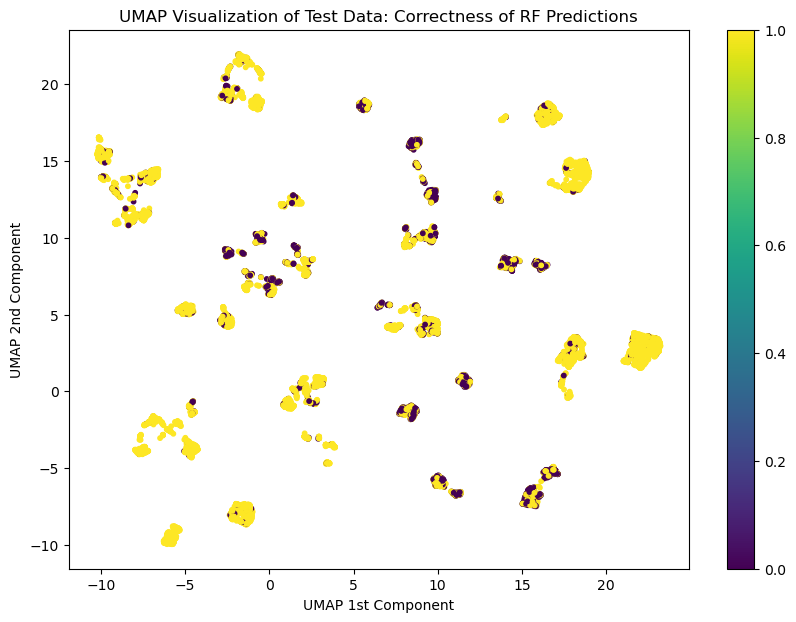

In [60]:
# 3. Plot the UMAP-transformed test data, colored by correctness of prediction
plt.figure(figsize=(10,7))
plt.scatter(X_t4_test_transformed[:, 0], X_t4_test_transformed[:, 1], c=is_correct_test, cmap='viridis', s=10)
plt.colorbar()
plt.gca().set_title('UMAP Visualization of Test Data: Correctness of RF Predictions')
plt.xlabel("UMAP 1st Component")
plt.ylabel('UMAP 2nd Component')
plt.show()